In [15]:
import mne
import matplotlib.pyplot as plt

filePath = "recordings/subj_5/session_1/block_1/Subject 5, Session 1, Block 1 Recording_FLEX2_213075_2024.05.08T16.44.48.07.00.md.edf"
raw = mne.io.read_raw_edf(filePath, preload=True)

Extracting EDF parameters from /Users/jonathan/Documents/coding/alljoined/stimulus-emotiv/recordings/subj_5/session_1/block_1/Subject 5, Session 1, Block 1 Recording_FLEX2_213075_2024.05.08T16.44.48.07.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 37887  =      0.000 ...   147.996 secs...


/var/folders/14/hz9wkgxn73dbs6fw9cz1vlsr0000gn/T/ipykernel_56454/2544977276.py:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(filePath, preload=True)


In [16]:
raw.info

Measurement date,"May 08, 2024 16:44:48 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,127 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


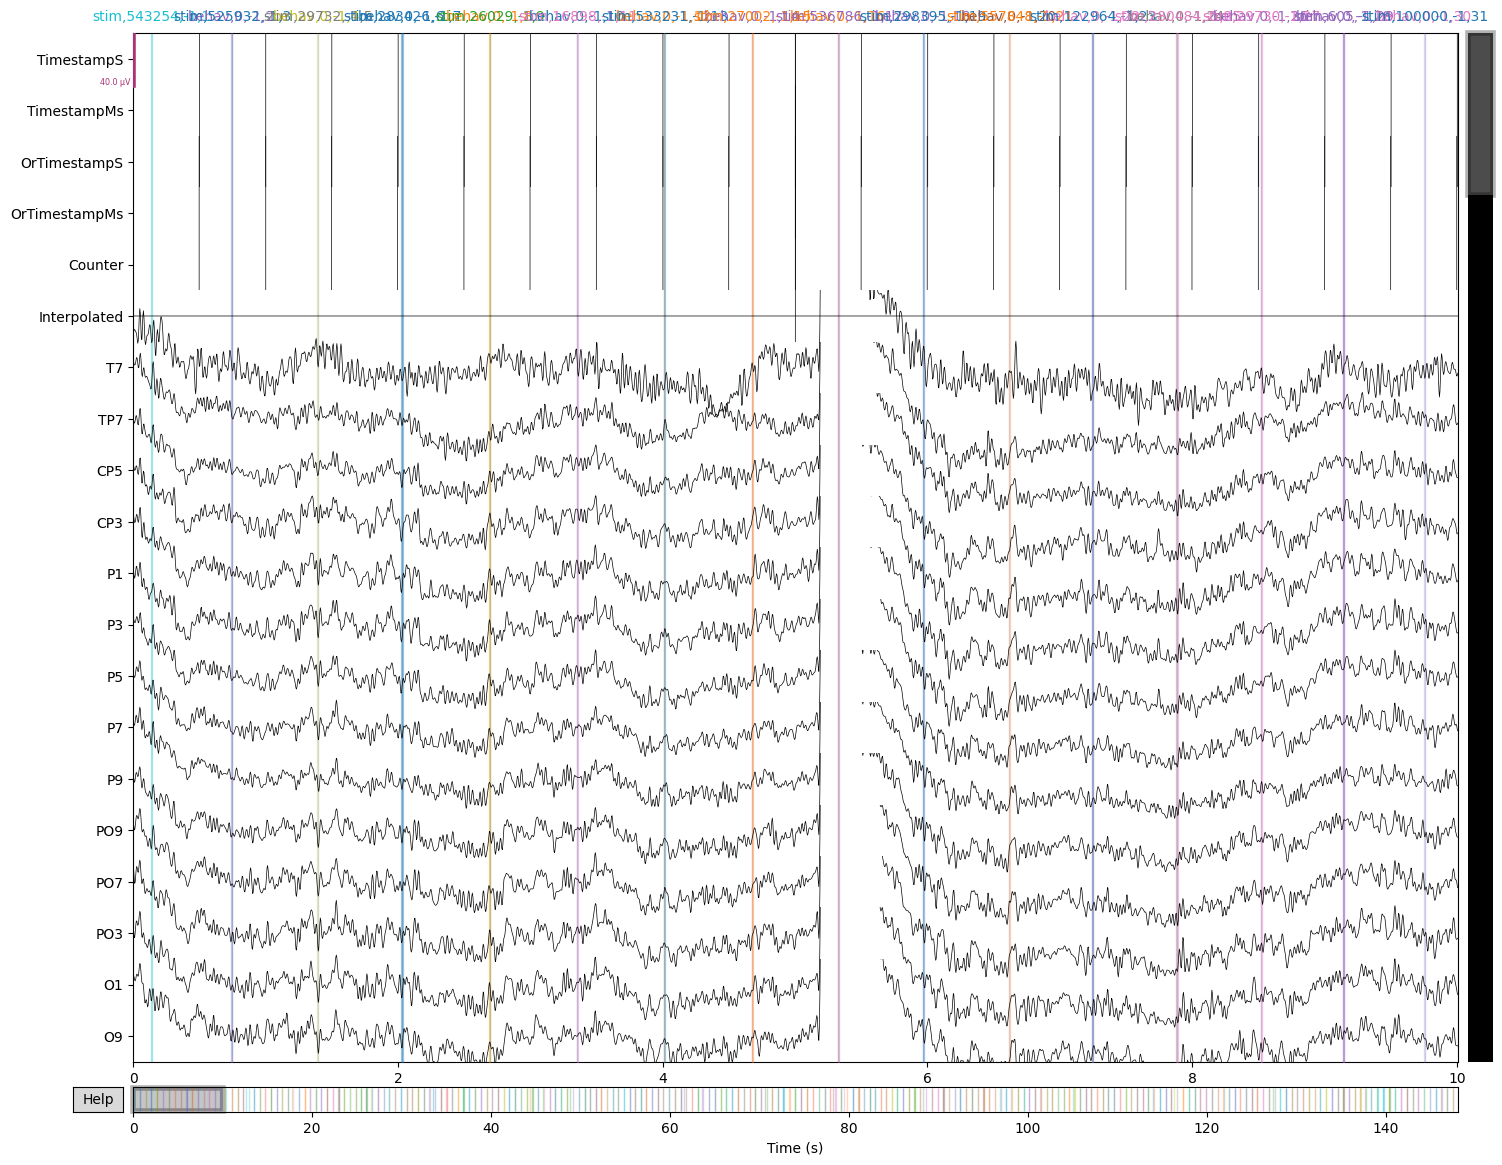

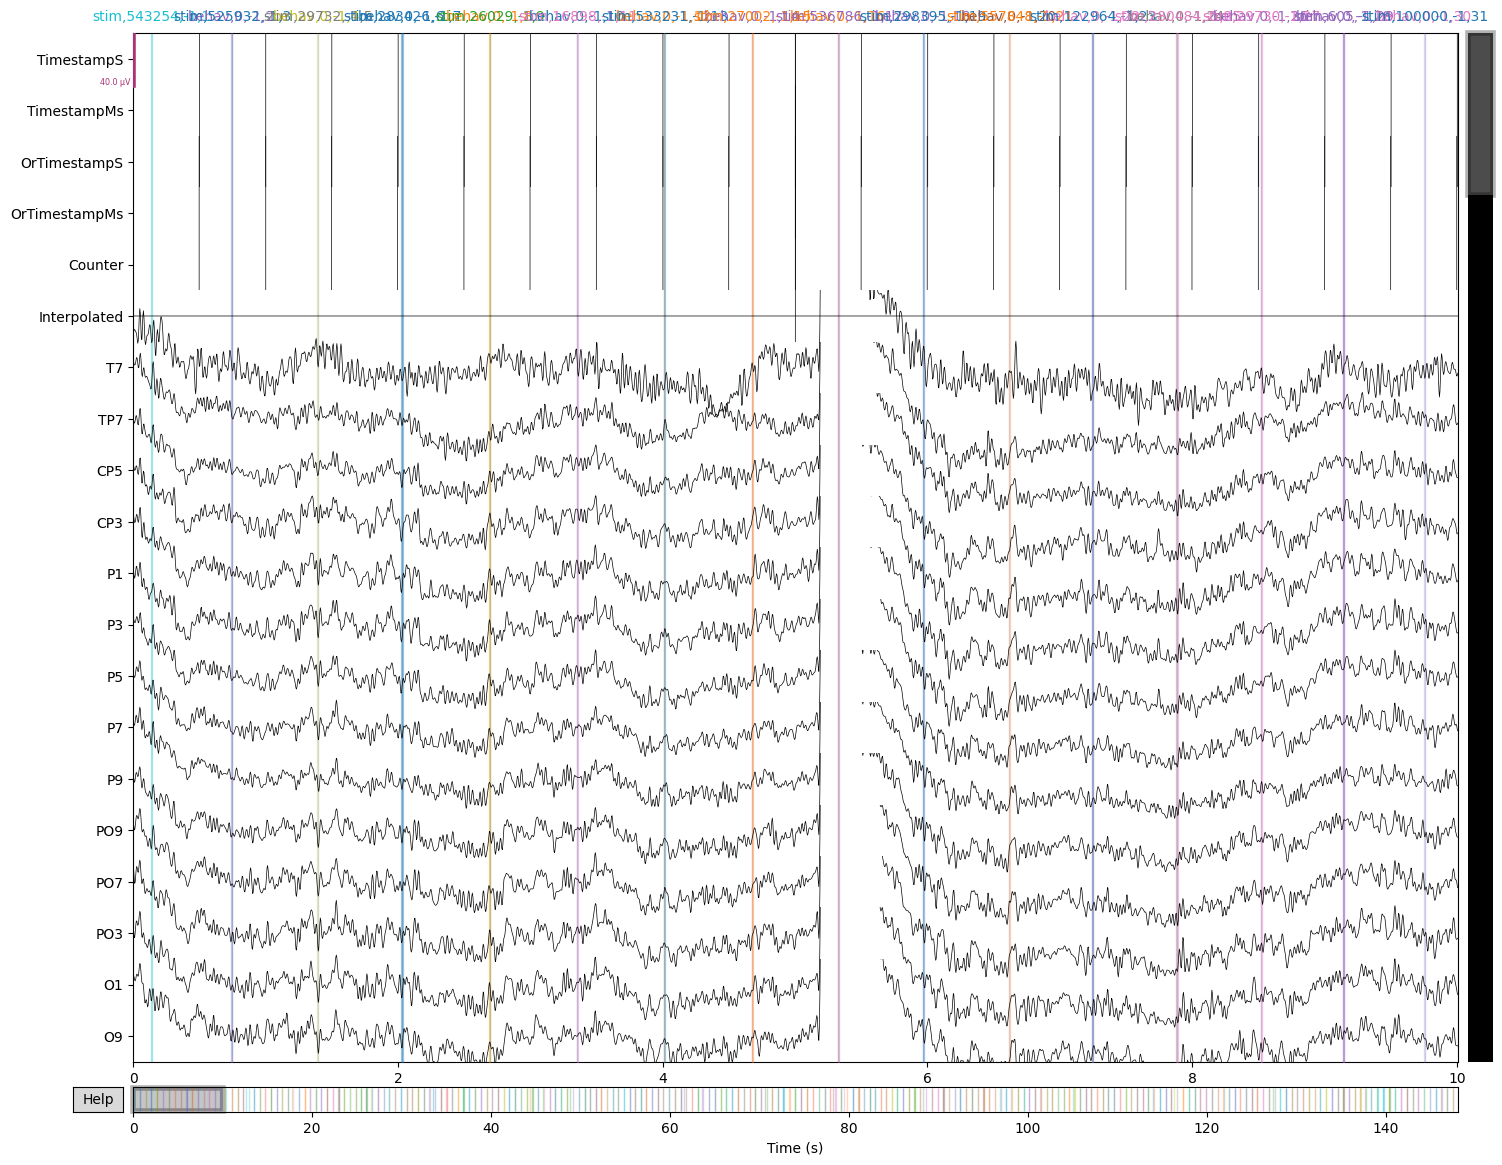

In [17]:
raw.plot()

In [122]:
for key, value in event_id.items():
    if value == 414:
        print(key)
        break

stim,543254,-1,1


In [124]:
events

array([[   35,     0,   414],
       [  190,     0,    49],
       [  191,     0,   388],
       ...,
       [37596,     0,   259],
       [37759,     0,   175],
       [37762,     0,   449]])

In [128]:
# List of channel names that are EEG electrodes
eeg_channels = [
    'T7', 'TP7', 'CP5', 'CP3', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO9', 'PO7', 'PO3',
    'O1', 'O9', 'Pz', 'POz', 'Oz', 'Iz', 'O10', 'O2', 'PO4', 'PO8', 'PO10', 'P10',
    'P8', 'P6', 'P4', 'P2', 'CP4', 'CP6', 'TP8', 'T8'
]

# Restrict data to only these EEG channels using the new recommended method
raw.pick(eeg_channels)

# Load events from annotations in the raw data
events, event_id = mne.events_from_annotations(raw)
# TODO: double check

# Create dictionaries for stimulus and behavior event IDs
stim_event_ids = {key: value for key, value in event_id.items() if key.startswith('stim')}
behav_event_ids = {key: value for key, value in event_id.items() if key.startswith('behav')}
code_to_desc = {v: k for k, v in event_id.items()}

# Since stim and behav codes increment sequentially, assume events are paired in order
dataset = []
sfreq = 256
sample_time_ms = 1000/sfreq
for i in range(len(events) - 1):  # Exclude the last event to avoid out-of-range error
    stim_time = events[i, 0]
    stim_id = events[i, 2]
    if stim_id in stim_event_ids.values():
        event_desc = code_to_desc[stim_id]  # Get the descriptive event string
        stim_value = int(event_desc.split(',')[1])  # The second item is the stimulus value

        behav_time = events[i+1, 0] 
        behav_id = events[i+1, 2]
        event_desc = code_to_desc[behav_id]
        behav_value = int(event_desc.split(',')[1])

        # Recall behavioural mapping:
        # 0: is_oddball and not space_pressed (-1 reaction time)
        # 1: not is_oddball and space_pressed
        # 2: is_oddball and space_pressed
        # 3: is_oddball and not space_pressed (-1 reaction time)
        if behav_value == 0 or behav_value == 3:
            reaction_time = None
        elif behav_value == 1 or behav_value == 2:
            reaction_time = (behav_time - stim_time)*sample_time_ms
        
        coco_id = stim_value
        if stim_value == 100000:
            prev_stim_id = events[i-2, 2]
            event_desc = code_to_desc[prev_stim_id]
            coco_id = int(event_desc.split(',')[1])
            stim_time = events[i-2, 0]
        
        record = {
            "time": stim_time*sample_time_ms,
            "coco_id": coco_id,
            "behaviour": behav_value,
            "reaction_time": reaction_time
        }

        # Save record only if record is oddball, or if record isn't oddball but next one is
        next_is_oddball = False
        if i+2 < len(events):
            next_stim_id = events[i+2,2]
            event_desc = code_to_desc[next_stim_id] 
            next_stim_value = int(event_desc.split(',')[1])
            next_is_oddball = (next_stim_value == 100000)

        if stim_value == 100000 or not next_is_oddball:
            dataset.append(record)

# epochs = mne.Epochs(raw, events, event_id=stim_event_ids, tmin=-0.05, tmax=0.60, preload=True)

Used Annotations descriptions: ['behav,0,-1,10', 'behav,0,-1,100', 'behav,0,-1,102', 'behav,0,-1,104', 'behav,0,-1,108', 'behav,0,-1,110', 'behav,0,-1,112', 'behav,0,-1,114', 'behav,0,-1,116', 'behav,0,-1,118', 'behav,0,-1,12', 'behav,0,-1,120', 'behav,0,-1,122', 'behav,0,-1,124', 'behav,0,-1,126', 'behav,0,-1,128', 'behav,0,-1,130', 'behav,0,-1,132', 'behav,0,-1,134', 'behav,0,-1,136', 'behav,0,-1,138', 'behav,0,-1,14', 'behav,0,-1,142', 'behav,0,-1,146', 'behav,0,-1,148', 'behav,0,-1,152', 'behav,0,-1,156', 'behav,0,-1,158', 'behav,0,-1,16', 'behav,0,-1,160', 'behav,0,-1,162', 'behav,0,-1,164', 'behav,0,-1,166', 'behav,0,-1,168', 'behav,0,-1,170', 'behav,0,-1,172', 'behav,0,-1,174', 'behav,0,-1,176', 'behav,0,-1,178', 'behav,0,-1,18', 'behav,0,-1,180', 'behav,0,-1,182', 'behav,0,-1,184', 'behav,0,-1,186', 'behav,0,-1,188', 'behav,0,-1,190', 'behav,0,-1,196', 'behav,0,-1,198', 'behav,0,-1,2', 'behav,0,-1,20', 'behav,0,-1,202', 'behav,0,-1,204', 'behav,0,-1,206', 'behav,0,-1,208', 'beh

In [80]:
events

array([[   35,     0,   414],
       [  190,     0,    49],
       [  191,     0,   388],
       ...,
       [37596,     0,   259],
       [37759,     0,   175],
       [37762,     0,   449]])

In [77]:
stim_to_behav_mapping

{414: (0, 190),
 388: (0, 355),
 349: (0, 519),
 334: (0, 689),
 282: (0, 858),
 267: (0, 1026),
 397: (0, 1196),
 308: (0, 1363),
 400: (0, 1527),
 352: (0, 1693),
 434: (0, 1855),
 262: (0, 2017),
 330: (0, 2181),
 348: (0, 2340),
 454: (0, 2496),
 244: (2, 2627),
 351: (0, 2826),
 407: (0, 2988),
 248: (3, 3156),
 419: (1, 3232),
 441: (0, 3466),
 433: (0, 3625),
 413: (0, 3782),
 357: (0, 3946),
 426: (0, 4107),
 271: (0, 4265),
 359: (0, 4422),
 253: (2, 4538),
 395: (0, 4750),
 364: (0, 4907),
 254: (2, 5055),
 420: (0, 5221),
 412: (0, 5386),
 445: (0, 5552),
 410: (0, 5709),
 447: (0, 5875),
 374: (0, 6040),
 381: (0, 6202),
 377: (0, 6363),
 314: (0, 6519),
 372: (0, 6675),
 255: (2, 6791),
 442: (0, 7007),
 337: (0, 7169),
 333: (0, 7331),
 405: (0, 7500),
 355: (0, 7662),
 280: (0, 7828),
 389: (0, 7985),
 394: (0, 8154),
 444: (0, 8316),
 319: (0, 8477),
 232: (2, 8591),
 370: (0, 8800),
 356: (0, 8965),
 281: (0, 9128),
 295: (0, 9280),
 398: (0, 9450),
 327: (0, 9618),
 3

In [79]:
dataset = {}

# Map from event codes to their descriptive strings
event_id_to_stim = {v: k for k, v in stim_event_ids.items()}
event_id_to_behav = {v: k for k, v in behav_event_ids.items()}

for i, epoch_event in enumerate(epochs.events):
    stim_time = epoch_event[0]  # Onset time of the stimulus
    event_code = epoch_event[2]  # Event code which is a key in stim_event_ids
    event_desc = event_id_to_stim[event_code]  # Get the descriptive event string
    stim_value = int(event_desc.split(',')[1])  # The second item is the stimulus value

    # Get the corresponding behavior event, if it exists
    (behav_value, behav_time) = stim_to_behav_mapping.get(event_code, 'No matching behavior event')
    print(stim_time, stim_value, behav_time, behav_value)
    break

   

35 543254 190 0


len(epochs)